#Rossmann Kaggle Competition

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

Loading and exploring Data

In [8]:
train = pd.read_csv("train.csv", parse_dates = ['Date'])

C:\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [9]:
store = pd.read_csv("store.csv")

In [10]:
test = pd.read_csv("test.csv", parse_dates = ['Date'])

In [11]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [12]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [13]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910,4,2015,0,NaN,NaN,NaN


In [14]:
def clean_data(data):
    
    data = pd.merge(data,store, left_on='Store',right_on = 'Store',how='left')
    data.loc[data.Open.isnull(),'Open'] = 0
    
    #add extra date columns
    data['month'] = data.Date.apply(lambda x: x.month)
    data['day'] = data.Date.apply(lambda x: x.day)
    data['year'] = data.Date.apply(lambda x: x.year)
    data['wkofyr'] = data.Date.apply(lambda x: x.weekofyear)
    data.drop(['Date'], axis = 1, inplace= True)
    
    # Calculate time competition open time in months
    data['CompetitionOpen'] = 12 * (data.year - data.CompetitionOpenSinceYear) + (data.month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, inplace = True)

    # Promo open time in months
    data['PromoOpen'] = 12 * (data.year - data.Promo2SinceYear) + (data.wkofyr - data.Promo2SinceWeek) / float(4)
    data['PromoOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['Promo2SinceYear', 'Promo2SinceWeek'], axis = 1, inplace = True)

    # Get promo months
    data['p_1'] = data.PromoInterval.apply(lambda x: x[:3] if type(x) == str else 0)
    data['p_2'] = data.PromoInterval.apply(lambda x: x[4:7] if type(x) == str else 0)
    data['p_3'] = data.PromoInterval.apply(lambda x: x[8:11] if type(x) == str else 0)
    data['p_4'] = data.PromoInterval.apply(lambda x: x[12:15] if type(x) == str else 0)
    
    #Get Dummies for Categorical         
    data = pd.get_dummies(data, columns = ['p_1', 'p_2', 'p_3', 'p_4', 
                                           'StateHoliday' , 
                                           'StoreType', 
                                           'Assortment'])
    data.drop(['Store',
               'PromoInterval', 
               'p_1_0', 'p_2_0', 'p_3_0', 'p_4_0', 
               'StateHoliday_0', 
               'year'], axis=1,inplace=True)


    # Fill in missing values
    data = data.fillna(0)
    data = data.sort_index(axis=1)

    return data

In [15]:
#some pre cleaning
train = train[train.Sales > 0] # Remove $0 Sales
data = train[train['Open'] != 0]

In [17]:
# Process training data
data = clean_data(data)
print('training data processed')

training data processed


In [18]:
# Set up training data
X_train = data.drop(['Sales', 'Customers'], axis = 1)
y_train = data.Sales.values

In [19]:
# Fit random forest model
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)
print('model fit')

model fit


In [20]:
# Process test data
test = clean_data(test)

In [21]:
# Ensure same columns in test data as training
for col in data.columns:
    if col not in test.columns:
        test[col] = np.zeros(test.shape[0])

In [22]:
test_ids = test.sort_index(axis=1).set_index('Id')
print('test data loaded and processed')

test data loaded and processed


In [23]:
# Make predictions
X_test = test.drop(['Sales','Customers','Id'], axis=1).values
y_test = rf.predict(X_test)

In [111]:
# Make Submission
result = pd.DataFrame({'Id': test_ids.index.values, 'Sales': y_test}).set_index('Id')
result = result.sort_index()
result.to_csv('submission.csv')
print('submission created')

submission created


#Model Validation and tuning

In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [25]:
forest = RandomForestRegressor(n_jobs = -1, n_estimators = 100)
forest = forest.fit(Xtrain, Ytrain)
predictY = forest.predict(Xtest) 

In [27]:
forest.score(X_train, y_train)

0.94891608303839969

In [28]:
forest.score(X_test, y_test)

0.82514900798201174

 1) Assortment_a                   0.404860
 2) Assortment_b                   0.135809
 3) Assortment_c                   0.066570
 4) CompetitionDistance            0.062501
 5) CompetitionOpen                0.062029
 6) DayOfWeek                      0.052207
 7) Open                           0.040475
 8) Promo                          0.024171
 9) Promo2                         0.022082
10) PromoOpen                      0.018402
11) SchoolHoliday                  0.016905
12) StateHoliday_a                 0.015607
13) StateHoliday_b                 0.014718
14) StateHoliday_c                 0.013483
15) StoreType_a                    0.009056
16) StoreType_b                    0.006748
17) StoreType_c                    0.003666
18) StoreType_d                    0.003558
19) day                            0.003410
20) month                          0.003377
21) p_1_Feb                        0.002875
22) p_1_Jan                        0.002828
23) p_1_Mar                     

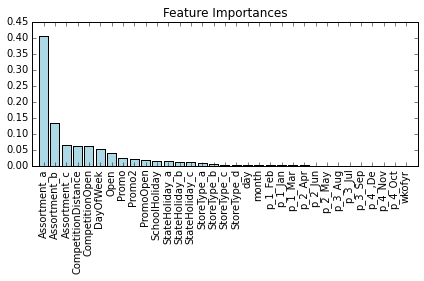

In [129]:
feat_labels = Xtrain.columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Xtrain.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[f],importances[indices[f]]))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color='lightblue',
        align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

In [ ]:
#CV search
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False]
              }

grid_search = GridSearchCV(forest, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

In [ ]:
print grid_search.best_params_